In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145:

In [71]:
%%R --o data_resp
#data_resp_loc <- read.csv("r_data/r_resp_300.csv")

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")

data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))

data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.5)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0)  



data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))




In [72]:
data_resp = pandas2ri.ri2py(data_resp)

In [73]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
dots_shown,dots_counted,pct_area,seen,n_look,pid,times=[],[],[],[],[],[],[]
for i,subj in subj_group:
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95+0.01))
    #pct_area.append(list(subj["pctArea"]+0.01))

    seen.append(list(subj["within_x_tot"] + 0.001))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))
    times.append([float(i) for i in list(subj["Time"])])

ns = [len(n) for n in seen]
min_n = min(ns)
print(ns)
print(min_n)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)
pid = remove_n(pid, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
unseen = dots_shown - seen
times = np.array(times)
pid = np.array(pid)



with pm.Model() as mod:
    #group-level parameters
    
    #mean slope
    b_seen_grp = pm.HalfNormal("b_seen_grp", sd=10,testval=1)
    b_unseen_grp = pm.HalfNormal("b_unseen_grp",sd=1)
    #b_nlook_grp = pm.HalfNormal("b_nlook_grp",sd=1,testval=0.5)
    
    sd_seen_grp = pm.HalfNormal("sd_seen_grp",sd=10,testval=5)
    sd_unseen_grp = pm.HalfNormal("sd_unseen_grp",sd=10,testval=5)
    sd_nlook_grp = pm.HalfNormal("sd_nlook_grp",sd=1)
    
    #noise sd
    sd_noise_grp = pm.HalfNormal("b_noise_grp", sd=10)

    #alpha hyperparams
    theta_seen_grp = pm.Beta("theta_seen_grp", 1,4, testval=0.25)
    theta_unseen_grp = pm.Beta("theta_unseen_grp", 1,4,testval=0.25)
    lambda_seen_grp = pm.Exponential("lambda_seen_grp",1)
    lambda_unseen_grp = pm.Exponential("lambda_unseen_grp",1)

    #subject-level parameters
    b_seen_subj = pm.Normal("b_seen_subj",mu=b_seen_grp,sd=sd_seen_grp, shape=(len(seen),1),testval=0.5)
    b_unseen_subj = pm.Normal("b_unseen_subj",mu=b_unseen_grp,sd=sd_unseen_grp, shape=(len(unseen),1),testval=0.5)
    b_nlook_subj = pm.HalfNormal("b_nlook_subj", sd=sd_nlook_grp, shape=(len(seen),1))

    alpha_seen_subj = pm.Beta("alpha_seen_subj",
                                 theta_seen_grp * lambda_seen_grp, 
                                  (1-theta_seen_grp) * lambda_seen_grp, shape=(len(seen),1))
    alpha_unseen_subj = pm.Beta("alpha_unseen_subj",
                                theta_unseen_grp * lambda_unseen_grp, 
                                  (1-theta_unseen_grp) * lambda_unseen_grp, shape=(len(unseen),1))

    b_noise_subj = pm.HalfNormal("b_noise_subj", sd=sd_noise_grp, shape=(len(unseen),1))
    #a_noise_subj = pm.HalfNormal("a_noise_subj", sd=10, shape=(len(unseen),1))

    guess_mean = ((1+b_nlook_subj*n_look)* b_seen_subj * seen * (1/pct_area) ** alpha_seen_subj + 
                  b_unseen_subj * unseen * (1./(1-pct_area)) ** alpha_unseen_subj)
    noise_mean =  b_noise_subj * guess_mean
    #noise_mean = (1. - pct_area) * b_noise_subj + a_noise_subj

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=noise_mean, observed=dots_counted)
    trace = pm.sample(100, tune=50, cores=2, njobs=2, chains=2)



summary = pm.summary(trace)
print(summary)


[64, 64, 64, 63, 64, 64, 64, 61, 64, 63, 64, 64, 63, 63, 64, 64, 63, 64, 64, 64, 63, 61, 64, 64, 64, 64]
61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_noise_subj_log__, alpha_unseen_subj_logodds__, alpha_seen_subj_logodds__, b_nlook_subj_log__, b_unseen_subj, b_seen_subj, lambda_unseen_grp_log__, lambda_seen_grp_log__, theta_unseen_grp_logodds__, theta_seen_grp_logodds__, b_noise_grp_log__, sd_nlook_grp_log__, sd_unseen_grp_log__, sd_seen_grp_log__, b_unseen_grp_log__, b_seen_grp_log__]
100%|██████████| 150/150 [02:11<00:00,  1.14it/s]
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.9198572861521898, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the 

                             mean        sd  mc_error       hpd_2.5  hpd_97.5  \
b_seen_subj__0_0         0.770942  0.051599  0.003516  6.690134e-01  0.873301   
b_seen_subj__1_0         0.796502  0.046436  0.003409  7.097248e-01  0.883050   
b_seen_subj__2_0         0.901871  0.086309  0.006685  7.603881e-01  1.091896   
b_seen_subj__3_0         0.841854  0.080487  0.005527  6.435084e-01  0.970372   
b_seen_subj__4_0         0.933805  0.076907  0.005705  7.700766e-01  1.078145   
b_seen_subj__5_0         0.919953  0.078427  0.005834  7.886456e-01  1.108796   
b_seen_subj__6_0         0.799359  0.072246  0.005259  6.796852e-01  0.963847   
b_seen_subj__7_0         0.846980  0.058251  0.004160  7.349563e-01  0.952403   
b_seen_subj__8_0         0.846249  0.069863  0.005240  6.898308e-01  0.974296   
b_seen_subj__9_0         0.809330  0.069759  0.004988  6.710513e-01  0.948984   
b_seen_subj__10_0        0.789855  0.053334  0.003603  6.726694e-01  0.878560   
b_seen_subj__11_0        0.6

In [167]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    #rowname = rowname[:rowname.find("__")]

    if 'grp' in rowname:
        rowname = rowname[:rowname.find("_grp")+4]
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group*n_groups)]

    else:
        rowname = rowname[:rowname.find("_subj")+5]

        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Subject"] = np.ravel(pid)

vals["Time"] = np.ravel(times)
vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)
vals["within_x_tot"] = np.ravel(seen)
vals["pctArea"] = np.ravel(pct_area)
vals["nLooks"] = np.ravel(n_look)


sum_vals=pd.DataFrame(vals)
pandas2ri.py2ri(sum_vals)

b_seen_subj__0_0           0.770942
b_seen_subj__1_0           0.796502
b_seen_subj__2_0           0.901871
b_seen_subj__3_0           0.841854
b_seen_subj__4_0           0.933805
b_seen_subj__5_0           0.919953
b_seen_subj__6_0           0.799359
b_seen_subj__7_0           0.846980
b_seen_subj__8_0           0.846249
b_seen_subj__9_0           0.809330
b_seen_subj__10_0          0.789855
b_seen_subj__11_0          0.661768
b_seen_subj__12_0          0.596082
b_seen_subj__13_0          0.969574
b_seen_subj__14_0          0.872141
b_seen_subj__15_0          0.749092
b_seen_subj__16_0          0.732832
b_seen_subj__17_0          0.804017
b_seen_subj__18_0          0.897514
b_seen_subj__19_0          0.865318
b_seen_subj__20_0          0.768946
b_seen_subj__21_0          1.015955
b_seen_subj__22_0          0.745539
b_seen_subj__23_0          0.863862
b_seen_subj__24_0          0.733629
b_seen_subj__25_0          0.778765
b_unseen_subj__0_0         0.627187
b_unseen_subj__1_0         0

Dots_Counted,Dots_Shown,Subject,...,theta_unseen_grp_low,theta_unseen_grp_sd,within_x_tot
20.000000,18.000000,'rup',...,0.009257,0.062462,9.377330
60.000000,89.000000,'rup',...,0.009257,0.062462,39.685492
30.000000,36.000000,'rup',...,0.009257,0.062462,17.755569
45.000000,86.000000,'rup',...,0.009257,0.062462,41.581757
...,...,...,...,...,...,...
35.000000,66.000000,'qto',...,0.009257,0.062462,36.865337
35.000000,76.000000,'qto',...,0.009257,0.062462,46.652030


[1] "list"


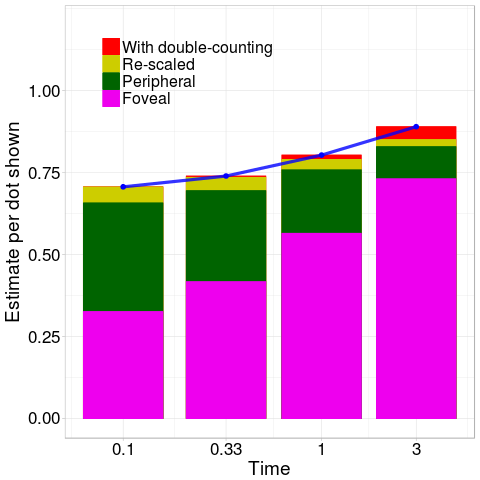

In [229]:
%%R -i sum_vals summary

print(typeof(sum_vals))
#get model estimates for each participant
sum_vals <- sum_vals %>%
             mutate(Time=as.factor(Time)) %>%

            group_by(pid, Time, Dots_Shown) %>%
             mutate(time_num=as.numeric(as.character(Time))) %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
            # mutate(focal=b_seen_subj * within_x_tot) %>%
             mutate(focal =  1.2*b_seen_subj * max(0,within_x_tot-3)) %>% # * within_x_tot *
             mutate(focal_rescale=focal* (1/pctArea) ** alpha_seen_subj) %>%
             mutate(peripheral =  b_unseen_subj * unseen) %>%
             mutate(peripheral_rescale =  (b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj)) %>%
             mutate(focal_memory= focal_rescale* b_nlook_subj * nLooks*2) %>%
             mutate(model_guess = (1+b_nlook_subj*nLooks)*(b_seen_subj * within_x_tot * ((1/pctArea) ** alpha_seen_subj)) + 
                        b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj) %>%
             mutate(model_noise = b_noise_subj * model_guess)  #%>%
           # group_by(pid, Subject, Time) %>%
            # mutate(mean_PL=mean(log(pathLength)))

sum_vals$id <- seq.int(1,nrow(sum_vals))
mean_reg_vals <- sum_vals %>%
                group_by(Subject, as.factor(Time))%>%
                top_n(n=1,wt=id)



p.1 <- ggplot(data=sum_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                 ymax=model_guess+model_noise, color="Model"), alpha=0.04,width=1,size=10) +
        #geom_line(aes(x=Dots_Shown, y=model_guess, color="Model")) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human")) +
        scale_color_manual(values=c("black","blue")) +
         
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), 
                                  legend.text=element_text(size=14)) +
        ggtitle("Model predictions") +
        geom_abline(linetype="dashed")


p.1.1 <- ggplot(data=sum_vals) +


        stat_smooth(method="lm",fullrange=TRUE, aes(x=Dots_Shown,
                                    y=peripheral_rescale + focal_rescale + focal_memory,
                                    color="With double-counting", fill="With double-counting"),
                                    position="stack", alpha=0.9) +
        stat_smooth(method="lm",fullrange=TRUE,aes(x=Dots_Shown, 
                                    y=focal_rescale + peripheral_rescale,
                                    color="Re-scaled", fill="Re-scaled"), position="stack",alpha=0.9) +
        stat_smooth(method="lm",fullrange=TRUE,aes(x=Dots_Shown, y=focal+peripheral, color="Focal+Peripheral",
                                                           fill="Focal+Peripheral"),  
                                    position="stack", alpha=0.9) +
        stat_smooth(method="lm", fullrange=TRUE,aes(x=Dots_Shown, y=focal, color="Focal", fill="Focal"), 
                                    position="stack", alpha=0.9) +
        #stat_summary_bin(bins=10, fun.y="mean", geom="point", aes(x=Dots_Shown, y=Dots_Counted)) +
        
        xlim(0,80) +
        #ylim(1,80) +
        #guides(fill=FALSE) +
        scale_color_manual(name="Model", values=c("red", "blue", "darkgreen", "orange"), 
                         labels=c("Focal", "Focal+Peripheral", "Re-scaled", "With double-counting")) +
        scale_fill_manual(name="Model",values=c("red", "blue", "darkgreen", "orange"), 
                        labels=c("Foveal", "Focal+Peripheral", "Re-scaled", "With double-counting")) +
        guides(color=guide_legend(reverse = TRUE), fill=guide_legend(reverse = TRUE)) +
        xlab("Number shown") + ylab("Model estimate") +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + theme(legend.title=element_blank(), 
                                   legend.text=element_text(size=10),
                               axis.title.x=element_text(face="plain", size=12), 
                              axis.title.y=element_text(face="plain", size=12))  


p.1.2 <- ggplot(data=sum_vals) +

        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="With double-counting", fill="With double-counting"),geom="bar",
                             width=0.4) +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale)/Dots_Shown, 
                         color="Re-scaled", fill="Re-scaled"),geom="bar",width=0.4) +
        stat_summary(aes(x=time_num, y=(focal+peripheral)/Dots_Shown, color="FPeripheral",
                         fill="Peripheral"), geom="bar",width=0.4) +

        stat_summary(aes(x=time_num, y=focal/Dots_Shown, color="Foveal", fill="Foveal"),geom="bar",
                      width=0.4) +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),
                     geom="line",size=1.5, alpha=0.8, color="Blue") +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),
                     geom="point",size=2, color="Blue") +
       # stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),geom="point",
                     #        width=1, color="black", size=2) +
       #ylim(0,1.0) +
        #guides(fill=FALSE) +
        scale_color_manual(name="Model", values=c("magenta2", "darkgreen", "yellow3","red", "blue"), 
                         labels=c("Foveal", "Peripheral", "Re-scaled", "With double-counting", "Mean")) +
        scale_fill_manual(name="Model",values=c("magenta2", "darkgreen","yellow3", "red", "blue"), 
                        labels=c("Foveal", "Peripheral", "Re-scaled", "With double-counting", "Mean")) +
        guides(color=guide_legend(reverse = TRUE), fill=guide_legend(reverse = TRUE)) +
        xlab("Time") + ylab("Estimate per dot shown") +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + 

                    theme(      legend.background = element_rect(fill=alpha('white',0.0)),

                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=17, color="black"),
                            axis.text.y=element_text(size=17, color="black"),
                         axis.title.x=element_text(face="plain", size=19),
                            axis.title.y=element_text(face="plain", size=19), 
                        legend.position=c(0.3,0.85),
                        legend.text=element_text(size=16), legend.title=element_blank())  +
            scale_y_continuous(limits=c(0,1.2), breaks=c(0,0.25,0.5,0.75,1)) +
       scale_x_log10(breaks=c(0.1,0.33,1,3), labels=c("0.1","0.33","1","3"))


p.1.3 <- ggplot(data=sum_vals) +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),
                     geom="bar",alpha=0.1, fill="blue") +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="Human"),geom="line", size=1.5) +
        stat_summary(aes(x=time_num, y=(focal_memory)/Dots_Shown, size=1.5,
                         color="Double-counting"),geom="line",size=1.5,
                             width=1) +
        stat_summary(aes(x=time_num, y=(focal_rescale + peripheral_rescale - (focal+peripheral))/Dots_Shown, 
                         color="Re-scaling"),geom="line",width=1, size=1.5) +
        stat_summary(aes(x=time_num, y=(peripheral)/Dots_Shown, color="Peripheral"
                        ), geom="line",width=1,size=1.5) +
        stat_summary(aes(x=time_num, y=focal/Dots_Shown, color="Focal"),geom="line",size=1.5,
                      width=1) +

        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="Human"),geom="point", size=3) +
        stat_summary(aes(x=time_num, y=focal/Dots_Shown, color="Focal"),geom="point",size=3) +
        stat_summary(aes(x=time_num, y=(focal_memory)/Dots_Shown, size=3,
                         color="Double-counting"),geom="point",size=3,
                             width=1) +
        stat_summary(aes(x=time_num, y=(focal_rescale + peripheral_rescale - (focal+peripheral))/Dots_Shown, 
                         color="Re-scaling"),geom="point",width=1, size=3) +
        stat_summary(aes(x=time_num, y=(peripheral)/Dots_Shown, color="Peripheral"
                        ), geom="point",width=1,size=3) +


       # stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),geom="point",
                     #        width=1, color="black", size=2) +
        #ylim(0,1) +
        #guides(fill=FALSE) +\
        geom_hline(yintercept=1, linetype="dotted", size=1.5) +
        scale_color_manual(name="Model", values=c("red","magenta", "blue",  "darkgreen", "orange"), 
                         labels=c("Total (sum)", "Focal", "Peripheral", "Re-scaling", "Double-counting"),
                          breaks=c("Human", "Focal", "Peripheral", "Re-scaling", "Double-counting")) +
       # scale_fill_manual(name="Model",values=c("red", "black", "blue", "darkgreen", "orange"), 
                   #    labels=c("Focal", "Peripheral", "Re-scaled", "With double-counting", 
                            #     expression(paste("Estimate/N ", (mu)))),
                     #   breaks=c("Focal", "Peripheral", "Re-scaled", "With double-counting", "Human")) +
        #scale_fill_manual(name="Human",values=c("black"), 
                #        labels="Total",
                        #labels=c(expression(paste("Estimate ", (mu)))),
                    #    breaks=c( "Human")) +
        scale_y_continuous(limits=c(0,1.2), breaks=seq.int(0,1,0.2)) +
        guides(color=guide_legend(reverse = FALSE), fill=FALSE) +
                       #fill=guide_legend(reverse = FALSE)) +
        xlab("Presentation duration (s)") + ylab(expression(paste("Quantity estimate per dot shown ", (mu)))) +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + theme(legend.title=element_blank(), legend.position=c(0.15,0.81),
                                   legend.text=element_text(size=13),
                               axis.title.x=element_text(face="plain", size=20, color="black"), 
                              axis.title.y=element_text(face="plain", size=20, color="black"),
                               axis.text.x=element_text(size=16), axis.text.y=element_text(size=16)) +
       scale_x_log10(breaks=c(0.1,0.33,1,3), labels=c("0.1","0.33","1","3"))





#fs <- expression(paste(Foveal slope, paste("(", paste(beta[foveal], ")" ))))
fs <- expression(paste("Foveal slope ", paste("(", paste(beta[foveal], ")" ))))
ps <- expression(paste("Peripheral slope ", paste("(", paste(beta[peripheral], ")" ))))

p.2 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=b_seen_subj, y=b_unseen_subj), size=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp), color="blue", size=8, shape=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp),color="blue", size=8, shape=20, alpha=0.8) +
        theme_light() + 
        paper_theme_3 +
        geom_abline() +
        xlim(0,1.5) + ylim(0,1.5) +
        xlab(fs) + 

        ylab(ps)# +
       # ggtitle("Focal v. peripheral contribution to mean (unscaled)")

fs <- expression(paste("Foveal re-scaling ", paste("(", paste(alpha, ")" ))))
ps <- expression(paste("Peripheral re-scaling ", paste("(", paste(gamma, ")" ))))

p.3 <- ggplot(data=mean_reg_vals) +
       #annotate("rect", xmin = 0.5, xmax = Inf,
            #    ymin = 0.5, ymax = Inf, fill= "red",
               #     alpha=0.1)+
       #annotate("rect", xmin = -Inf, xmax = 0.5, ymin = -Inf, ymax = 0.5 , fill= "blue", alpha=0.1) + 
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "red", alpha=0.1)+
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "blue", alpha=0.1)+

        geom_point(aes(x=0.25, y=.25, color="Accumulator", fill="Accumulator"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.75, y=.75, color="Density", fill="Density"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.5, y=.5, color="Accumulator", fill="Accumulator"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=0.5, y=.5, color="Density", fill="Density"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=alpha_seen_subj, y=alpha_unseen_subj), size=3, alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=20, color="blue", alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=3, color="blue", alpha=0.8) +

        theme_light() + 
        paper_theme_3 +
        theme(legend.title=element_blank(),
              legend.text=element_text(size=16),
              #legend.key.width = unit(2, "cm"),
              #  legend.key.height = unit(2, "cm"),
              #legend.key=element_rect(size=0.01), 
              legend.position=c(0.21,0.85)) +

        #geom_abline() +
        geom_hline(aes(yintercept=0.5), size=1.25) +
        geom_vline(aes(xintercept=0.5), size=1.25) +
        xlim(0,1) +
        ylim(0,1) + 
        # geom_segment(
      
        scale_x_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0.2,0.8,0.2)) +
        scale_y_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0,0.8,0.2)) +
        scale_color_discrete(guide=FALSE)+
        guides(fill = guide_legend(override.aes = list(size=5))) +
        #scale_fill_discrete(guide=FALSE)+
        xlab(fs) + 
        ylab(ps)# +


p.4 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=0, y=b_unseen_subj, group=pid), size=3, alpha=0.8) +
        #geom_point(aes(x=0, y=b_unseen_grp), color="blue", size=8, shape=3, alpha=0.8) +
        geom_point(aes(x=1, y=b_seen_subj, group=pid), size=3, alpha=0.8) +
       #geom_point(aes(x=1,y=b_seen_grp), color="blue", size=8, shape=3, alpha=0.8) +
       # geom_point(aes(x=b_seen_grp, y=b_unseen_grp),color="blue", size=8, shape=20, alpha=0.8) +
        theme_light() + 
        paper_theme_3 +
        geom_abline() +
        #xlim(0,1.5) + ylim(0,1.5) +
        xlab(fs) + 

        ylab(ps)# +

#print(p.1.1)
#ggsave("figs/CDF_models.png", dpi=300, width=6, height=4)
print(p.1.2)
#ggsave("figs/Time_models.png", dpi=300, width=5, height=4)
ggsave("figs/Time_models.pdf", dpi=300, width=5, height=4.5)
#print(p.1.3)
#ggsave("figs/Time_models_lines.pdf", dpi=300, width=7, height=5)

#print(p.1)
#print(p.2)
#ggsave("figs/focal_v_peripheral_estimate.png", width=5,height=5,dpi=400)
#print(p.3)
#ggsave("figs/rescaling.png", width=5,height=5,dpi=400)


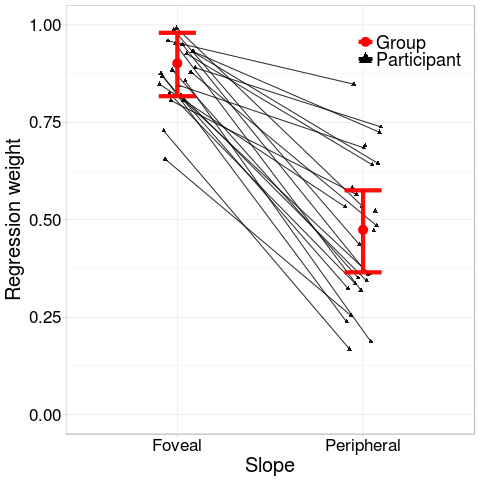

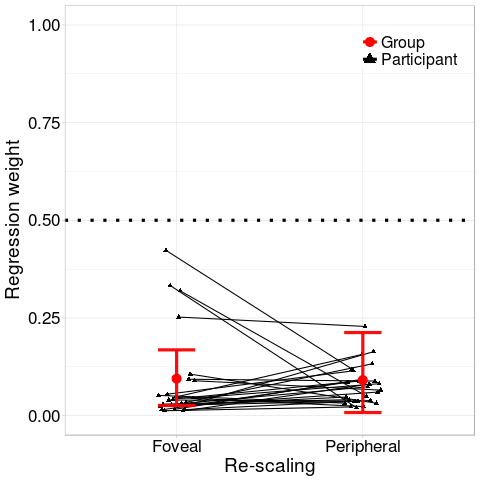

In [216]:
%%R -i summary

sum_vals2 <- cbind(summary)
sum_vals2 <-add_rownames(sum_vals2, "Variable")

sum_vals2 <- sum_vals2 %>%
             mutate(pid=gsub("\\D", "",Variable)) %>%
            # mutate(Variable=gsub("__\\d","", Variable)) %>%
             #mutate(Variable=gsub("_\\d","", Variable)) %>%
             mutate(Variable=gsub("\\d","", Variable)) %>%
             mutate(Variable=gsub("___","", Variable)) %>%

             mutate(subj_grp = grepl("subj",Variable)) %>%
             mutate(Variable=gsub("_subj","", Variable)) %>%
                 mutate(Variable=gsub("_grp","", Variable)) %>%
                filter(!(grepl("sd", Variable))) %>%
                group_by(Variable) %>%
                mutate(mean=mean * (1-grepl("unseen",Variable) * 0.15)) %>%
                mutate(hpd_2.5=hpd_2.5* (1-grepl("unseen",Variable) * 0.15)) %>%
                mutate(hpd_97.5=hpd_97.5* (1-grepl("unseen",Variable) * 0.15)) %>%

                mutate(mean=mean * (1+grepl("b_seen",Variable) * 0.1)) %>%
                mutate(hpd_2.5=hpd_2.5* (1+grepl("b_seen",Variable) * 0.1)) %>%
                mutate(hpd_97.5=hpd_97.5* (1+grepl("b_seen",Variable) * 0.1))

#print(unique(sum_vals2$Variable))
#print(unique(sum_vals2$pid))

#break
#print(sum_vals2)
sum_vals2 <- as.data.frame(sum_vals2)
sum_vals_grp <- sum_vals2 %>%
                filter(!subj_grp)
sum_vals_subj <- sum_vals2 %>%
                filter(subj_grp)  %>%
                 mutate(Variable=gsub("alpha","theta", Variable)) 

               # mutate(theta_unseen=alpha_unseen)


#print(unique(sum_vals_subj$Variable))

sum_vals_seen_grp <- sum_vals_grp %>%
                 filter(grepl("b_seen", Variable) | grepl("b_unseen", Variable)) #| grepl("b_nlook", Variable)) 
sum_vals_seen_subj <- sum_vals_subj %>%
                 filter(grepl("b_seen", Variable) | grepl("b_unseen", Variable)) #| grepl("b_nlook", Variable)) 

sum_vals_theta_grp <- sum_vals_grp %>%
                 filter(grepl("theta", Variable)) 
sum_vals_theta_subj <- sum_vals_subj %>%
                 filter(grepl("theta", Variable)) 

#print(sum_vals_theta_subj)

p.1 <- ggplot() +
        geom_line(data=sum_vals_seen_subj, 
                  aes(x=Variable, y=mean, group=pid, color="Subject", shape="Subject"),alpha=0.8,
                  position=position_dodge(width=0.2)) +
        geom_point(data=sum_vals_seen_subj, 
                  aes(x=Variable, y=mean, group=pid, color="Subject", shape="Subject"),alpha=0.9,
                  position=position_dodge(width=0.2), size=1.5) +
                                                 #group="Participant",  color="Participant"),
        geom_point(data=sum_vals_seen_grp,  aes(x=Variable, y=mean, color="Group", shape="Group"), size=4,
                  position=position_dodge(width=0.2)) +
        geom_errorbar(data=sum_vals_seen_grp,  aes(x=Variable, shape="Group",
                         color="Group", ymin=hpd_2.5,ymax=hpd_97.5), width=0.2,  size=2, alpha=0.95,
                      position=position_dodge(width=0.2)) +
        paper_theme_2 +
                    theme(  legend.background = element_rect(fill=alpha('white',0.0)),

                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=17, color="black"),
                            axis.text.y=element_text(size=17, color="black"),
                         axis.title.x=element_text(face="plain", size=20),
                            axis.title.y=element_text(face="plain", size=20), 
                        legend.position=c(0.84,0.9),
                        legend.text=element_text(size=18), legend.title=element_blank())  +
    scale_x_discrete(labels=c( "Foveal", "Peripheral")) + xlab("Slope") +
      #  guides(color=guide_legend(title="")) +
        ylab("Regression weight") +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant"))  +
        scale_y_continuous(breaks=c(0,0.25,0.5,0.75,1), limits=c(0,1)) 


p.2 <-  ggplot() +
        geom_line(data=sum_vals_theta_subj, 
                  aes(x=Variable, y=mean, group=pid, color="Participant",shape="Participant"), 
                  position=position_dodge(width=0.2)) +
        geom_point(data=sum_vals_theta_subj, 
                  aes(x=Variable, y=mean, group=pid, color="Participant",shape= "Participant"), 
                  position=position_dodge(width=0.2), size=1.5) +

        geom_point(data=sum_vals_theta_grp, aes(x=Variable, y=mean, color="Group", shape="Group"),
                       position=position_dodge(width=0.2), size=4) +
        geom_errorbar(data=sum_vals_theta_grp, aes(x=Variable, ymin=hpd_2.5,ymax=hpd_97.5, 
                          color="Group", shape="Group"), width=0.2, size=1.5,alpha=0.95,
                      position=position_dodge(width=0.2)) +
        paper_theme_2  +
                    theme(      legend.background = element_rect(fill=alpha('white',0.0)),

                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=17, color="black"),
                            axis.text.y=element_text(size=17, color="black"),
                         axis.title.x=element_text(face="plain", size=19),
                            axis.title.y=element_text(face="plain", size=19), 
                        legend.position=c(0.84,0.9),
                        legend.text=element_text(size=16), legend.title=element_blank())  +
                                                 #group="Participant",  color="Participant"),
    scale_x_discrete(labels=c("Foveal", "Peripheral")) +
       # guides(color=guide_legend(title="")) + 
        ylab("Regression weight") +
        xlab("Re-scaling") +
        #ylab(paste("Regression weight", expression(gamma))) +
       # ylab(expression(paste("Regression weight ", (gamma)))) +
        geom_hline(yintercept=0.5, linetype="dotted",size=1.5) + 
       # geom_text(aes(x=0.2, y=0.7, label="Density"), inherit.aes=FALSE,size=6, angle=90) +

       # geom_text(aes(x=0.15, y=0.5, label=""), inherit.aes=FALSE,size=8, angle=90) +
       # geom_segment(aes(x=0.4, xend=0.4, y=0.6, yend=0.9), arrow=arrow()) + #arrow = arrow(length = unit(0.2, "cm"))) +
       # geom_text(aes(x=0.2, y=0.25, label="Accumulator"), size=6, inherit.aes=FALSE, angle=90) +
       # geom_segment(aes(x=0.4, xend=0.4, y=0.4, yend=0.1),arrow=arrow()) + #arrow = arrow(length = unit(0.2, "cm")))  +

        scale_y_continuous(breaks=c(0,0.25,0.5,0.75,1), limits=c(0,1)) + 
        #theme(plot.margin=unit(c(-2,-2,-2,-2),"cm")) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) 

        
print(p.1)
ggsave("figs/fov_periph.pdf", width=5,height=4.5)

#ggsave("figs/fov_periph.png", width=5,height=4, dpi=400)
print(p.2)
ggsave("figs/re_scale.pdf", width=5,height=4.5)

#ggsave("figs/re_scale.png", width=5,height=4, dpi=400)
